# AI Kepler - demo

## Packages import

In [1]:
# conda env
!echo $CONDA_PREFIX

/opt/homebrew/Caskroom/miniforge/base/envs/PhySR


In [2]:
# External packages
import torch
import os
import time as time
import numpy as np

# Pyplot
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from sklearn.neighbors import KernelDensity

from IPython.display import display, clear_output


In [3]:
# Internal code import
from physr.physym import Batch
from physr.physym import ExecuteProgram
from physr.physym import Program
from physr.physym import Reward



In [4]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

cpu


In [5]:
torch.cuda.is_available()

False

## ML utils

### Cell

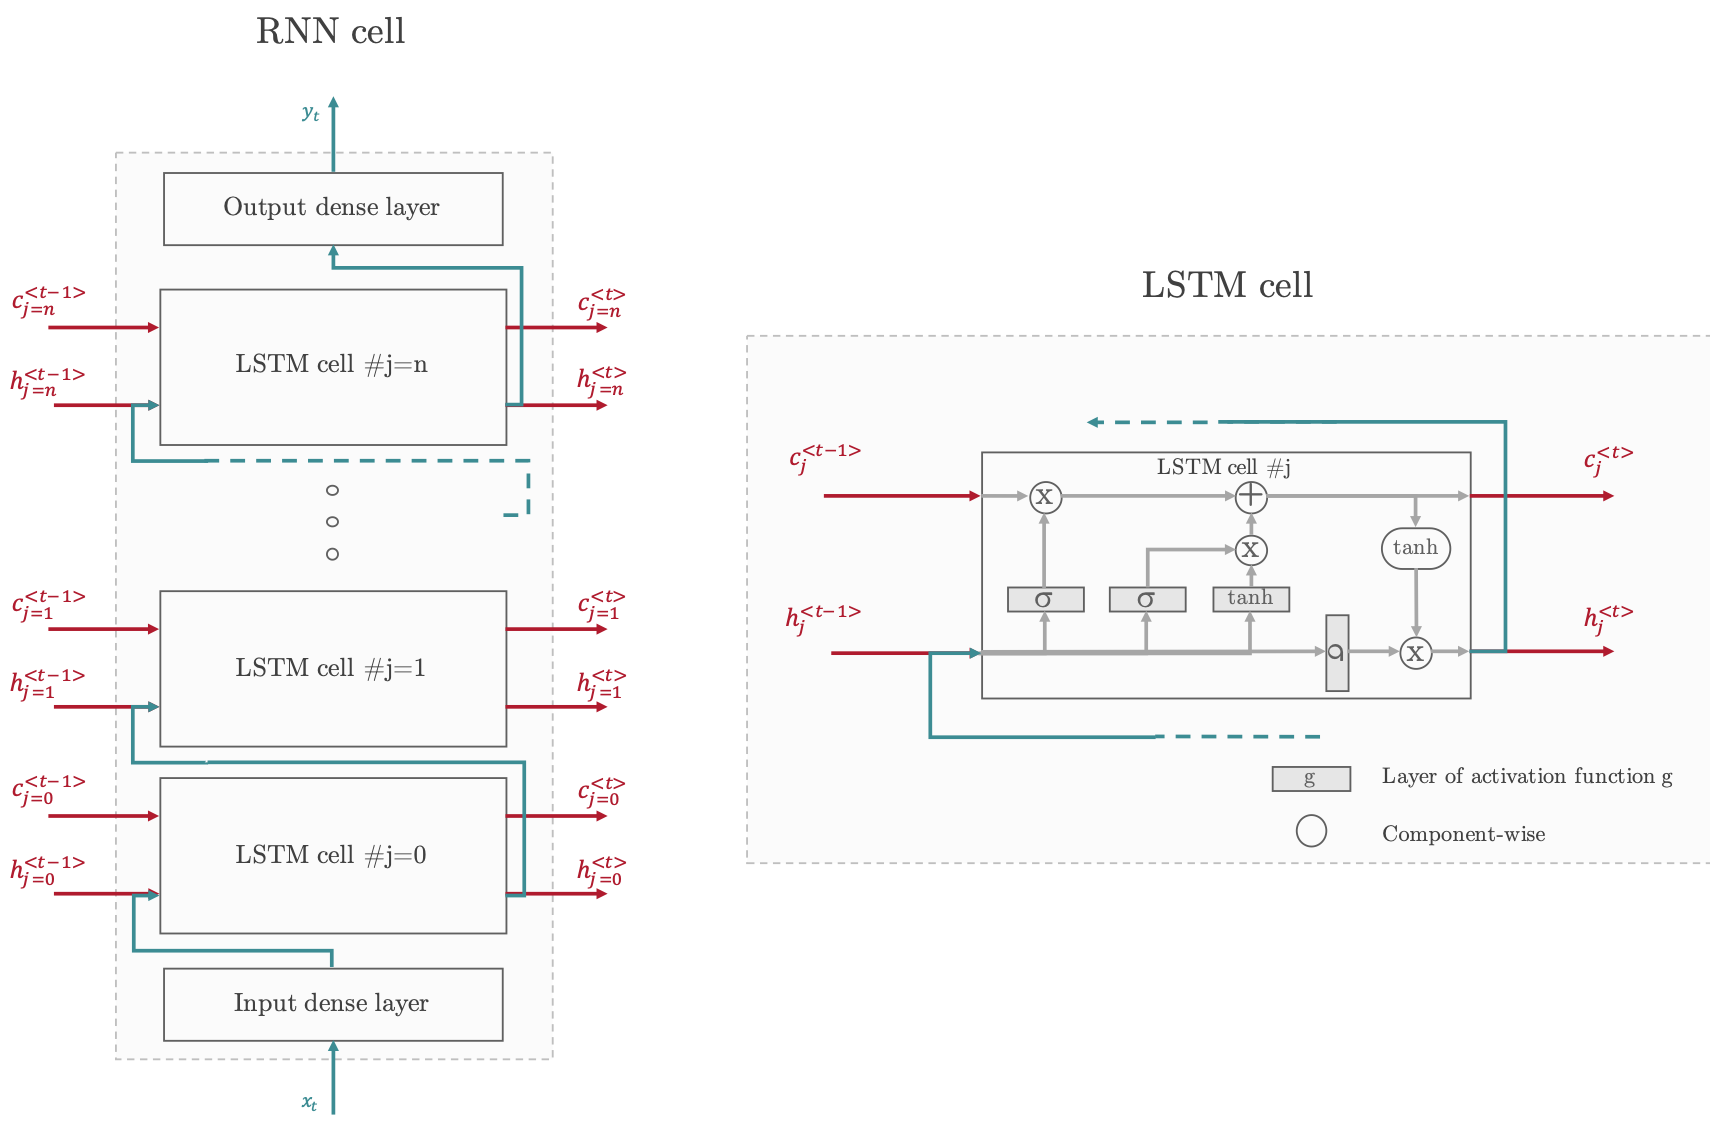

In [6]:
class Cell(torch.nn.Module):
    """
        A custom RNN cell for symbolic regression.
        Attributes
        ----------
        input_size  : int
            Size of observation vector.
        n_layers    : int
            Number of stacked RNNs.
        hidden_size : int
            Number of hidden features in the RNN cells states.
        output_size : int
            Number of features ie number of choices possible in the library of tokens.

        input_dense       : torch.nn
            Input dense layer.
        stacked_cells     : list of torch.nn
            Stacked RNN cells.
        output_dense      : torch.nn
            Output dense layer.
        output_activation : function
            Output activation function.
            
        logTemperature : torch.tensor
            Annealing parameter
        
        Methods
        -------
        forward (input_tensor, states)
            RNN cell call returning categorical logits.
        get_zeros_initial_state (batch_size)
            Returns a cell state containing zeros.
        count_parameters()
            Returns number of trainable parameters.
            
        Examples
        -------
        #  RNN initialization ---------
        input_size  = 3*7 + 33
        output_size = 7
        hidden_size = 32
        n_layers    = 1
        batch_size  = 1024
        time_steps  = 30

        initial_states = torch.zeros(n_layers, 2, batch_size, hidden_size)
        initial_obs    = torch.zeros(batch_size, input_size)

        RNN_CELL = Cell(input_size  = input_size, 
                        output_size = output_size, 
                        hidden_size = hidden_size, 
                        n_layers    = n_layers)

        print(RNN_CELL)
        print("n_params = %i"%(RNN_CELL.count_parameters()))
        #  RNN run --------------
        observations = initial_obs
        states       = initial_states
        outputs      = []
        for _ in range (time_steps):
            output, states = RNN_CELL(input_tensor = observations, 
                                            states = states      )
            observations   = observations
            outputs.append(output)
        outputs = torch.stack(outputs)
        print("outputs shape = ", outputs.shape)

    """
    def __init__(self, input_size = 3*7+1, output_size = 7, hidden_size = 32, n_layers = 1):
        super().__init__()
        # --------- Input dense layer ---------
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.input_dense = torch.nn.Linear(self.input_size, self.hidden_size)
        # --------- Stacked RNN cells ---------
        self.n_layers      = n_layers
        self.stacked_cells = torch.nn.ModuleList([torch.nn.LSTMCell(input_size  = self.hidden_size, 
                                                                    hidden_size = self.hidden_size)
                             for _ in range(self.n_layers) ])
        # --------- Output dense layer ---------
        self.output_size       = output_size
        self.output_dense      = torch.nn.Linear(self.hidden_size, self.output_size)
        self.output_activation = lambda x: -torch.nn.functional.relu(x)
                                 #lambda x: torch.nn.functional.softmax(x, dim=1)
                                 #torch.sigmoid
        # --------- Annealing param ---------
        self.logTemperature = torch.nn.Parameter(1.54*torch.ones(1), requires_grad=True)
        
                
    def get_zeros_initial_state(self, batch_size):
        zeros_initial_state = torch.zeros(self.n_layers, 2, batch_size, self.hidden_size, requires_grad=False,)
        return zeros_initial_state

    def forward(self,  
                input_tensor,                                         # (batch_size, input_size) 
                states,                                               # (n_layers, 2, batch_size, hidden_size)
               ):
        # --------- Input dense layer ---------
        hx = self.input_dense(input_tensor)                           # (batch_size, hidden_size)
        # layer norm + activation
        # --------- Stacked RNN cells ---------
        new_states = [] # new states of stacked RNNs
        for i in range(self.n_layers):
            hx, cx = self.stacked_cells[i](hx,                        # (batch_size, hidden_size)
                                           (states[i,0,:,:],          # (batch_size, hidden_size)
                                            states[i,1,:,:]           # (batch_size, hidden_size)
                                           ))
            new_states.append(torch.stack([hx, cx]))
        # --------- Output dense layer ---------
        res = self.output_dense(hx) + self.logTemperature             # (batch_size, output_size) 
        res = self.output_activation(res)                             # (batch_size, output_size) 
        out_states = torch.stack(new_states)                          # (n_layers, 2, batch_size, hidden_size)
        # --------------- Return ---------------
        return res, out_states                                        # (batch_size, output_size), (n_layers, 2, batch_size, hidden_size)
    
    def count_parameters (self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        n_params = sum([np.prod(p.size()) for p in model_parameters])
        return n_params

### Loss

In [7]:
def safe_cross_entropy(p, logq, dim=-1):
    safe_logq = torch.where(p == 0, torch.ones_like(logq), logq)
    return -torch.sum(p*safe_logq, dim=dim)

def loss_func (logits_train, ideal_probs_train, R_train, baseline, lengths, gamma_decay, entropy_weight, ):
    """
    Loss function for reinforcing symbolic programs.
    Parameters
    ----------
    logits_train       : torch.tensor of shape (max_time_step, n_train, n_choices,)
    ideal_probs_train  : torch.tensor of shape (max_time_step, n_train, n_choices,)
    R_train            : torch.tensor of shape (n_train,)
    baseline           : float
    lengths            : torch.tensor of shape (n_train,)
    gamma_decay        : float
    entropy_weight     : float
    Returns
    -------
    loss : float
    """

    # Getting shape
    (max_time_step, n_train, n_choices,) = ideal_probs_train.shape
    
    # ----- Length mask -----
    # Lengths mask (avoids learning out of range of symbolic functions)
    
    mask_length_np = np.tile(np.arange(0, max_time_step), (n_train, 1)                             # (n_train, max_time_step,)
        ).astype(int) < np.tile(lengths, (max_time_step, 1)).transpose()                                                
    mask_length_np = mask_length_np.transpose().astype(float)                                      # (max_time_step, n_train,)
    mask_length    = torch.tensor(mask_length_np, requires_grad=False)                             # (max_time_step, n_train,)
    
    # ----- Entropy mask -----
    # Entropy mask (weighting differently along sequence dim)
    
    entropy_gamma_decay   = np.array([gamma_decay**t for t in range (max_time_step)])              # (max_time_step,)
    entropy_decay_mask_np = np.tile(entropy_gamma_decay, (n_train, 1)).transpose()*mask_length_np  # (max_time_step, n_train,)
    entropy_decay_mask    = torch.tensor(entropy_decay_mask_np, requires_grad=False)               # (max_time_step, n_train,)
        
    # ----- Loss : Gradient Policy -----
    
    # Normalizing over action dim probs and logprobs
    probs    = torch.nn.functional.softmax     (logits_train, dim=2)                               # (max_time_step, n_train, n_choices,)
    logprobs = torch.nn.functional.log_softmax (logits_train, dim=2)                               # (max_time_step, n_train, n_choices,)

    # Sum over action dim
    neglogp_per_step = safe_cross_entropy(ideal_probs_train, logprobs, dim=2)                      # (max_time_step, n_train,)
    # Sum over sequence dim
    neglogp = torch.sum(neglogp_per_step*mask_length, dim=0)                                       # (n_train,)
    
    # Mean over training samples of batch
    loss_gp = torch.mean((R_train-baseline)*neglogp) 
    
    # ----- Loss : Entropy -----
    
    # Sum over action dim
    entropy_per_step = safe_cross_entropy(probs, logprobs, dim=2)                                  # (max_time_step, n_train,)
    # Sum over sequence dim
    entropy = torch.sum(entropy_per_step*entropy_decay_mask, dim=0)                                # (n_train,)

    loss_entropy = -entropy_weight*torch.mean(entropy)
    
    # ----- Loss -----
    loss = loss_gp + loss_entropy
    
    return loss




### Learner

In [8]:
def learner (model, 
             optimizer, 
             n_epochs, 
             batch_reseter, 
             risk_factor, 
             gamma_decay,
             entropy_weight,
             verbose = True,
             stop_reward = 1.,
             stop_after_n_epochs = 50,
             run_logger     = None,
             run_visualiser = None,
            ):
    
    t000 = time.perf_counter()
    
    # Basic logs
    overall_max_R_history = []
    hall_of_fame          = []
    
    for epoch in range (n_epochs):
        
        if verbose>1: print("Epoch %i/%i"%(epoch, n_epochs))
        
        # -------------------------------------------------
        # --------------------- INIT  ---------------------
        # -------------------------------------------------

        # Reset new batch (embedding reset)
        batch = batch_reseter()
        batch_size    = batch.batch_size
        max_time_step = batch.max_time_step
        
        # Initial RNN cell input
        states = model.get_zeros_initial_state(batch_size)  # (n_layers, 2, batch_size, hidden_size)

        # Optimizer reset
        optimizer.zero_grad()

        # Candidates
        logits        = []
        actions       = []
        
        # Number of elite candidates to keep
        n_keep = int(risk_factor*batch_size)

        # -------------------------------------------------
        # -------------------- RNN RUN  -------------------
        # -------------------------------------------------

        # RNN run
        for i in range (max_time_step):

            # ------------ OBSERVATIONS ------------
            # (embedding output)
            observations = torch.tensor(batch.get_obs().astype(np.float32), requires_grad=False,) # (batch_size, obs_size)

            # ------------ MODEL ------------

            # Giving up to date observations
            output, states = model(input_tensor = observations,    # (batch_size, output_size), (n_layers, 2, batch_size, hidden_size)
                                            states = states      ) 

            # Getting raw prob distribution for action n°i
            outlogit = output                                         # (batch_size, output_size)

            # ------------ PRIOR ------------
            
            # (embedding output)
            prior_array = batch.prior().astype(np.float32)         # (batch_size, output_size)

            # 0 protection so there is always something to sample
            epsilon = 0 #1e-14 #1e0*np.finfo(np.float32).eps
            prior_array[prior_array==0] = epsilon
            
            # To log
            prior    = torch.tensor(prior_array, requires_grad=False) # (batch_size, output_size)
            logprior = torch.log(prior)                               # (batch_size, output_size)

            # ------------ SAMPLING ------------

            logit  = outlogit + logprior                              # (batch_size, output_size)
            action = torch.multinomial(torch.exp(logit),              # (batch_size,)
                                       num_samples=1)[:, 0]           
            
            # ------------ ACTION ------------

            # Saving action n°i
            logits       .append(logit)
            actions      .append(action)
            
            # Informing embedding of new action
            # (embedding input)
            batch.programs.append(action.cpu().detach().numpy())

        # -------------------------------------------------
        # ------------------ CANDIDATES  ------------------
        # -------------------------------------------------

        # Keeping prob distribution history for backpropagation
        logits         = torch.stack(logits        , dim=0)         # (max_time_step, batch_size, n_choices, )
        actions        = torch.stack(actions       , dim=0)         # (max_time_step, batch_size,)

        # Programs as numpy array for black box reward computation
        actions_array  = actions.cpu().detach().numpy()             # (max_time_step, batch_size,)

        # -------------------------------------------------
        # -------------------- REWARD ---------------------
        # -------------------------------------------------
        
        # (embedding output)
        R = batch.get_rewards()

        # -------------------------------------------------
        # ---------------- BEST CANDIDATES ----------------
        # -------------------------------------------------
        
        # index of elite candidates
        # copy to avoid negative stride problem
        # https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663/7
        keep    = R.argsort()[::-1][0:n_keep].copy()                              # (n_keep,)
        notkeep = R.argsort()[::-1][n_keep: ].copy()                              # (batch_size-n_keep,)

        # ----------------- Train batch : black box part (NUMPY) -----------------
        
        # Elite candidates 
        actions_array_train     = actions_array [:, keep]                         # (max_time_step, n_keep,)
        # Elite candidates as one-hot target probs
        ideal_probs_array_train = np.eye(batch.n_choices)[actions_array_train]    # (max_time_step, n_keep, n_choices,) 

        # Elite candidates rewards
        R_train = torch.tensor(R[keep], requires_grad=False)                      # (n_keep,)
        R_lim   = R_train.min()

        # Elite candidates as one-hot in torch
        # (non-differentiable tensors)
        ideal_probs_train = torch.tensor(                                         # (max_time_step, n_keep, n_choices,)  
                                ideal_probs_array_train.astype(np.float32), 
                                requires_grad=False,)                             
        
        # -------------- Train batch : differentiable part (TORCH) ---------------
        # Elite candidates pred logprobs
        logits_train            = logits[:, keep]                                 # (max_time_step, n_keep, n_choices,)

        # -------------------------------------------------
        # ---------------------- LOSS ---------------------
        # -------------------------------------------------

        # Lengths of programs
        lengths = batch.programs.n_lengths[keep]                                  # (n_keep,)

        # Reward baseline
        #baseline = RISK_FACTOR - 1
        baseline = R_lim

        # Loss
        loss_val = loss_func (logits_train      = logits_train, 
                              ideal_probs_train = ideal_probs_train, 
                              R_train           = R_train, 
                              baseline          = baseline, 
                              lengths           = lengths, 
                              gamma_decay       = gamma_decay, 
                              entropy_weight    = entropy_weight, )
        
        # -------------------------------------------------
        # ---------------- BACKPROPAGATION ----------------
        # -------------------------------------------------

        loss_val  .backward()
        optimizer .step()
        
        # -------------------------------------------------
        # ----------------- LOGGING VALUES ----------------
        # -------------------------------------------------
        
        # Basic logging (necessary for early stopper)
        if epoch == 0: 
            overall_max_R_history       = [R.max()]
            hall_of_fame                = [batch.programs.get_prog(R.argmax())]
        if epoch> 0:
            if R.max() > np.max(overall_max_R_history): 
                overall_max_R_history.append(R.max())
                hall_of_fame.append(batch.programs.get_prog(R.argmax()))
            else:
                overall_max_R_history.append(overall_max_R_history[-1])
        
        # Custom logging
        if run_logger is not None:
            run_logger.log(epoch    = epoch, 
                           batch    = batch, 
                           model    = model, 
                           rewards  = R, 
                           keep     = keep,
                           notkeep  = notkeep,
                           loss_val = loss_val)
        
        # -------------------------------------------------
        # ----------------- VISUALISATION -----------------
        # -------------------------------------------------           
        
        # Custom visualisation
        if run_visualiser is not None:
            run_visualiser.visualise(run_logger = run_logger, batch = batch)
        
        # -------------------------------------------------
        # -------------------- STOPPER --------------------
        # -------------------------------------------------
        early_stop_reward_eps = 2*np.finfo(np.float32).eps
        
        # If above stop_reward (+/- eps) stop after [stop_after_n_epochs] epochs.
        if (stop_reward - overall_max_R_history[-1]) <= early_stop_reward_eps:
            if stop_after_n_epochs == 0: break
            stop_after_n_epochs -= 1
    
    t111 = time.perf_counter()
    if verbose:
        print("  -> Time = %f s"%(t111-t000))
    
    return overall_max_R_history, hall_of_fame

### Logger

In [9]:
class RunLogger:
    
    def __init__ (self):
        self.initialize()
        
    def initialize (self):
        # Epoch specific
        self.epoch = None
        
        self.overall_max_R_history        = []
        self.hall_of_fame                 = []
        
        self.epochs_history               = []
        self.loss_history                 = []
        
        self.mean_R_train_history         = []
        self.mean_R_history               = []
        self.max_R_history                = []
        
        self.R_history                    = []
        self.R_history_train              = []
        
        self.best_prog_complexity_history = []
        self.mean_complexity_history      = []
        
        self.n_physical                   = []
        self.lengths_of_physical          = []
        self.lengths_of_unphysical        = []
        
    def log(self, epoch, batch, model, rewards, keep, notkeep, loss_val):
        
        # Epoch specific
        self.epoch   = epoch
        self.R       = rewards
        self.batch   = batch
        self.keep    = keep
        self.notkeep = notkeep
        best_prog_idx_epoch  = rewards.argmax()
        self.best_prog_epoch = batch.programs.get_prog(best_prog_idx_epoch)
        self.programs_epoch  = batch.programs.get_programs_array()
        
        
        if epoch == 0: 
            self.overall_max_R_history       = [rewards.max()]
            self.hall_of_fame                = [batch.programs.get_prog(best_prog_idx_epoch)]
        if epoch> 0:
            if rewards.max() > np.max(self.overall_max_R_history): 
                self.overall_max_R_history.append(rewards.max())
                self.hall_of_fame.append(batch.programs.get_prog(best_prog_idx_epoch))
            else:
                self.overall_max_R_history.append(self.overall_max_R_history[-1])
        
        self.epochs_history         .append( epoch                             )
        self.loss_history           .append( loss_val.cpu().detach().numpy()   )
    
        self.mean_R_train_history   .append( rewards[keep].mean()              )
        self.mean_R_history         .append( rewards.mean()                    )
        self.max_R_history          .append( rewards.max()                     )
        
        
        self.R_history              .append( rewards                           )
        self.R_history_train        .append( rewards[keep]                     )

        self.best_prog_complexity_history .append(batch.programs.tokens.complexity[best_prog_idx_epoch].sum())
        self.mean_complexity_history      .append(batch.programs.tokens.complexity.sum(axis=1).mean())
        
        self.R_history_array        = np.array(self.R_history)
        self.R_history_train_array  = np.array(self.R_history_train)
        
        self.n_physical              .append( batch.programs.is_physical.sum() )
        self.lengths_of_physical     .append( self.batch.programs.n_lengths[ self.batch.programs.is_physical] )
        self.lengths_of_unphysical   .append( self.batch.programs.n_lengths[~self.batch.programs.is_physical] )
            
        self.pareto_logger()
    
    def pareto_logger(self,):
        curr_complexities = self.batch.programs.n_complexity
        curr_rewards      = self.R
        curr_batch        = self.batch
        
        # Init
        if self.epoch == 0:
            self.pareto_complexities  = np.arange(0,10*curr_batch.max_time_step)
            self.pareto_rewards       = np.full(shape=(self.pareto_complexities.shape), fill_value = np.NaN)
            self.pareto_programs      = np.full(shape=(self.pareto_complexities.shape), fill_value = None, dtype=object)

        # Update with current epoch info
        for i,c in enumerate(self.pareto_complexities):
            # Idx in batch of programs having complexity c
            arg_have_c = np.argwhere(curr_complexities.round() == c)
            if len(arg_have_c) > 0:
                # Idx in batch of the program having complexity c and having max reward
                arg_have_c_and_max = arg_have_c[curr_rewards[arg_have_c].argmax()]
                # Max reward of this program
                max_r_at_c = curr_rewards[arg_have_c_and_max]
                # If reward > currently max reward for this complexity or empty, replace
                if self.pareto_rewards[i] <= max_r_at_c or np.isnan(self.pareto_rewards[i]):
                    self.pareto_programs [i] = curr_batch.programs.get_prog(arg_have_c_and_max[0])
                    self.pareto_rewards  [i] = max_r_at_c
    
    def get_pareto_front(self,):
        # Postprocessing
        # Keeping only valid pareto candidates
        mask_pareto_valid = (~np.isnan(self.pareto_rewards)) & (self.pareto_rewards>0)
        pareto_rewards_valid      = self.pareto_rewards      [mask_pareto_valid]
        pareto_programs_valid     = self.pareto_programs     [mask_pareto_valid]
        pareto_complexities_valid = self.pareto_complexities [mask_pareto_valid]
        # Computing front
        pareto_front_r            = [pareto_rewards_valid       [0]]
        pareto_front_programs     = [pareto_programs_valid      [0]]
        pareto_front_complexities = [pareto_complexities_valid  [0]]
        for i,r in enumerate(pareto_rewards_valid):
            # Only keeping candidates with higher reward than candidates having a smaller complexity
            if r > pareto_front_r[-1]:
                pareto_front_r            .append(r)
                pareto_front_programs     .append(pareto_programs_valid     [i])
                pareto_front_complexities .append(pareto_complexities_valid [i])

        pareto_front_complexities = np.array(pareto_front_complexities)
        pareto_front_programs     = np.array(pareto_front_programs)
        pareto_front_r            = np.array(pareto_front_r)
        pareto_front_rmse         = ((1/pareto_front_r)-1)*self.batch.dataset.y_target.std().cpu().detach().numpy()
        
        return pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse
    
    @property
    def best_prog(self):
        return self.hall_of_fame[-1]

### Fitter

In [10]:
def fit(X, y, run_config, stop_reward = 1.):
     # todo: assert MAX_TIME_STEP>= max_length
     # todo: if run_config is None, make const
     # todo: replace stop_reward by stop_rmse
     # todo: no plot visualiser by default, text only
    def batch_reseter():
        batch = Batch.Batch (library_args          = run_config["library_config"],
                             priors_config         = run_config["priors_config"],
                             batch_size            = run_config["learning_config"]["batch_size"],
                             max_time_step         = run_config["learning_config"]["max_time_step"],
                             rewards_computer      = run_config["learning_config"]["rewards_computer"],
                             free_const_opti_args  = run_config["free_const_opti_args"],
                             X        = X,
                             y_target = y,
                             
                             )
        return batch

    batch = batch_reseter()

    def cell_reseter ():
        input_size  = batch.obs_size
        output_size = batch.n_choices
        cell = Cell (input_size  = input_size, 
                     output_size = output_size, 
                     hidden_size = run_config["cell_config"]["hidden_size"], 
                     n_layers    = run_config["cell_config"]["n_layers"])

        return cell
    
    cell      = cell_reseter ()
    optimizer = run_config["learning_config"]["get_optimizer"](cell)
    
    

    overall_max_R_history, hall_of_fame = learner (
                                                    model               = cell, 
                                                    optimizer           = optimizer, 
                                                    n_epochs            = run_config["learning_config"]["n_epochs"], 
                                                    batch_reseter       = batch_reseter,
                                                    risk_factor         = run_config["learning_config"]["risk_factor"],
                                                    gamma_decay         = run_config["learning_config"]["gamma_decay"],
                                                    entropy_weight      = run_config["learning_config"]["entropy_weight"],
                                                    verbose             = False,
                                                    stop_reward         = stop_reward,
                                                    stop_after_n_epochs = 50,
                                                    run_logger          = run_config["run_logger"],
                                                    run_visualiser      = run_config["run_visualiser"],
                                                   )
    
    return overall_max_R_history, hall_of_fame

### Visualiser

In [11]:
class RunVisualiser:
    
    def __init__ (self, epoch_refresh_rate = 10, save_path = None, do_show=True, do_save=False):
        self.epoch_refresh_rate = epoch_refresh_rate
        self.figsize   = (40,18)
        self.save_path = save_path
        self.do_show   = do_show
        self.do_save   = do_save
        
    def initialize (self):
        self.fig = plt.figure(figsize=self.figsize)
        gs  = gridspec.GridSpec(3, 3)
        self.ax0 = self.fig.add_subplot(gs[0, 0])
        self.ax1 = self.fig.add_subplot(gs[0, 1])
        div = make_axes_locatable(self.ax1)
        self.cax = div.append_axes("right", size="4%", pad=0.4)
        self.ax2 = self.fig.add_subplot(gs[1, 0])
        self.ax3 = self.fig.add_subplot(gs[1, 1])
        self.ax4 = self.fig.add_subplot(gs[:2, 2])
        # 3rd line
        self.ax5 = self.fig.add_subplot(gs[2, 0])
        self.ax6 = self.fig.add_subplot(gs[2, 1])
        div = make_axes_locatable(self.ax6)
        self.cax6 = div.append_axes("right", size="4%", pad=0.4)
        self.ax7 = self.fig.add_subplot(gs[2, 2])
        div = make_axes_locatable(self.ax7)
        self.cax7 = div.append_axes("right", size="4%", pad=0.4)

    def update_plot (self,):
        epoch      = self.run_logger.epoch
        run_logger = self.run_logger
        batch      = self.batch
        
        # -------- Reward vs epoch --------
        curr_ax = self.ax0
        curr_ax.clear()
        curr_ax.plot(run_logger.epochs_history, run_logger.mean_R_history        , 'b'            , linestyle='solid' , alpha = 0.6, label="Mean")
        curr_ax.plot(run_logger.epochs_history, run_logger.mean_R_train_history  , 'r'            , linestyle='solid' , alpha = 0.6, label="Mean train")
        curr_ax.plot(run_logger.epochs_history, run_logger.overall_max_R_history , 'k'            , linestyle='solid' , alpha = 1.0, label="Overall Best")
        curr_ax.plot(run_logger.epochs_history, run_logger.max_R_history         , color='orange' , linestyle='solid' , alpha = 0.6, label="Best of epoch")
        curr_ax.set_ylabel("Reward")
        curr_ax.set_xlabel("Epochs")
        curr_ax.legend()

        # -------- Reward distrbution vs epoch --------
        curr_ax = self.ax1
        cmap = plt.get_cmap("viridis")
        fading_plot_nepochs       = epoch
        fading_plot_ncurves       = 20
        fading_plot_max_alpha     = 1.
        fading_plot_bins          = 100
        fading_plot_kde_bandwidth = 0.05
        curr_ax.clear()
        self.cax.clear()  
        # Plotting last "fading_plot_nepochs" epoch on "fading_plot_ncurves" curves
        plot_epochs = []
        for i in range (fading_plot_ncurves+1):
            frac = i/fading_plot_ncurves
            plot_epoch = int(epoch - frac*fading_plot_nepochs)
            plot_epochs.append(plot_epoch)
            prog = 1 - frac
            alpha = fading_plot_max_alpha*(prog)
            # Histogram
            bins_dens = np.linspace(0., 1, fading_plot_bins) 
            kde = KernelDensity(kernel="gaussian", bandwidth=fading_plot_kde_bandwidth
                               ).fit(run_logger.R_history_train_array[plot_epoch][:, np.newaxis])
            dens = 10**kde.score_samples(bins_dens[:, np.newaxis])
            # Plot
            curr_ax.plot(bins_dens, dens, alpha=alpha, linewidth=0.5, c=cmap(prog))
        # Colorbar
        normcmap = plt.matplotlib.colors.Normalize(vmin=plot_epochs[0], vmax=plot_epochs[-1])
        cbar = self.fig.colorbar(plt.cm.ScalarMappable(norm=normcmap, cmap=cmap), cax=self.cax, pad=0.005)
        cbar.set_label('epochs', rotation=90,labelpad=30)     
        curr_ax.set_xlim([0, 1.])
        curr_ax.set_ylabel("Density")
        curr_ax.set_xlabel("Reward")

        # -------- Complexity --------
        curr_ax = self.ax2
        curr_ax.clear()
        curr_ax.plot(run_logger.epochs_history, run_logger.best_prog_complexity_history, 'orange', linestyle='solid'   ,  label="Best of epoch")
        curr_ax.plot(run_logger.epochs_history, run_logger.mean_complexity_history     , 'b',      linestyle='solid'   ,  label="Mean")
        curr_ax.set_ylabel("Complexity")
        curr_ax.set_xlabel("Epochs")
        curr_ax.legend()    

        # -------- Loss --------
        curr_ax = self.ax3
        curr_ax.clear()
        curr_ax.plot(run_logger.epochs_history, run_logger.loss_history, 'grey', label="loss")
        curr_ax.set_ylabel("Loss")
        curr_ax.set_xlabel("Epochs")
        curr_ax.legend()    

        # -------- Fit --------
        curr_ax = self.ax4
        curr_ax.clear()
        # Cut on dim
        cut_on_dim = 0
        x = batch.dataset.X[cut_on_dim]
        # Plot data
        x_expand = 0.5
        n_plot = 100
        stack = []
        for x_dim in batch.dataset.X:
            x_dim_min = x.min().cpu().detach().numpy()
            x_dim_max = x.max().cpu().detach().numpy()
            x_dim_plot = torch.tensor(np.linspace(x_dim_min-x_expand, x_dim_max+x_expand, n_plot))
            stack.append(x_dim_plot)
        X_plot = torch.stack(stack).to(DEVICE)
        x_plot = X_plot[cut_on_dim]
        
        # Data points
        curr_ax.plot(x.cpu().detach().numpy(), batch.dataset.y_target.cpu().detach().numpy(), 'ko', markersize=10)
        x_plot_cpu = x_plot.detach().cpu().numpy()

        # Best overall program
        y_plot = run_logger.best_prog(X_plot).detach().cpu().numpy()
        if y_plot.shape == (): y_plot = np.full(n_plot, y_plot)
        curr_ax.plot(x_plot_cpu, y_plot, color='k', linestyle='solid', linewidth=2)

        # Best program of epoch
        y_plot = run_logger.best_prog_epoch(X_plot).detach().cpu().numpy()
        if y_plot.shape == (): y_plot = np.full(n_plot, y_plot)
        curr_ax.plot(x_plot_cpu, y_plot, color='orange', linestyle='solid', linewidth=2)

        # Train programs
        for prog in run_logger.programs_epoch[run_logger.keep]:
            y_plot =  prog(X_plot).detach().cpu().numpy()
            if y_plot.shape == (): y_plot = np.full(n_plot, y_plot)
            curr_ax.plot(x_plot_cpu, y_plot, color='r', alpha=0.05, linestyle='solid')

        # Other programs
        for prog in run_logger.programs_epoch[run_logger.notkeep]:
            y_plot =  prog(X_plot).detach().cpu().numpy()
            if y_plot.shape == (): y_plot = np.full(n_plot, y_plot)
            curr_ax.plot(x_plot_cpu, y_plot, color='b', alpha=0.05, linestyle='solid')

        # Plot limits
        y_min = y.min().cpu().detach().numpy()
        y_max = y.max().cpu().detach().numpy()
        curr_ax.set_ylim(y_min-0.1*np.abs(y_min), y_max+0.1*np.abs(y_max))
        custom_lines = [
            Line2D([0], [0], color='k',      lw=3),
            Line2D([0], [0], color='orange', lw=3),
            Line2D([0], [0], color='r',      lw=3),
            Line2D([0], [0], color='b',      lw=3),]
        curr_ax.legend(custom_lines, ['Overall Best', 'Best of epoch', 'Train', 'Others'])
        
        # -------- Number of physical progs --------
        curr_ax = self.ax5
        curr_ax.plot(run_logger.epochs_history, run_logger.n_physical, 'grey', label="Physical count")
        curr_ax.set_xlabel("Epochs")
        curr_ax.set_ylabel("Physical count")
        
        
        # -------- Lengths of physical distribution vs epoch --------
        curr_ax  = self.ax6
        curr_cax = self.cax6

        cmap = plt.get_cmap("viridis")
        fading_plot_nepochs       = epoch
        fading_plot_ncurves       = 20
        fading_plot_max_alpha     = 1.
        fading_plot_bins          = 100
        fading_plot_kde_bandwidth = 1.
        curr_ax.clear()
        curr_cax.clear()
        # Plotting last "fading_plot_nepochs" epoch on "fading_plot_ncurves" curves
        plot_epochs = []
        for i in range (fading_plot_ncurves+1):
            frac = i/fading_plot_ncurves
            plot_epoch = int(epoch - frac*fading_plot_nepochs)
            plot_epochs.append(plot_epoch)
            prog = 1 - frac
            alpha = fading_plot_max_alpha*(prog)
            # Distribution data
            distrib_data = self.run_logger.lengths_of_physical[plot_epoch]
            # If non empty selection, compute pdf and plot it
            if distrib_data.shape[0] > 0:
                # Histogram
                bins_dens = np.linspace(0., self.run_logger.batch.max_time_step, fading_plot_bins) 
                kde = KernelDensity(kernel="gaussian", bandwidth=fading_plot_kde_bandwidth
                                   ).fit(distrib_data[:, np.newaxis])
                dens = 10**kde.score_samples(bins_dens[:, np.newaxis])
                # Plot
                curr_ax.plot(bins_dens, dens, alpha=alpha, linewidth=0.5, c=cmap(prog))
        # Colorbar
        normcmap = plt.matplotlib.colors.Normalize(vmin=plot_epochs[0], vmax=plot_epochs[-1])
        cbar = self.fig.colorbar(plt.cm.ScalarMappable(norm=normcmap, cmap=cmap), cax=curr_cax, pad=0.005)
        cbar.set_label('epochs', rotation=90,labelpad=30)     
        curr_ax.set_xlim([0, self.run_logger.batch.max_time_step])
        curr_ax.set_ylabel("Density")
        curr_ax.set_xlabel("Lengths (physical)")
        
        # -------- Lengths of unphysical distribution vs epoch --------
        curr_ax  = self.ax7
        curr_cax = self.cax7
        curr_fig = self.fig

        cmap = plt.get_cmap("viridis")
        fading_plot_nepochs       = epoch
        fading_plot_ncurves       = 20
        fading_plot_max_alpha     = 1.
        fading_plot_bins          = 100
        fading_plot_kde_bandwidth = 1.
        curr_ax.clear()
        curr_cax.clear()
        # Plotting last "fading_plot_nepochs" epoch on "fading_plot_ncurves" curves
        plot_epochs = []
        for i in range (fading_plot_ncurves+1):
            frac = i/fading_plot_ncurves
            plot_epoch = int(epoch - frac*fading_plot_nepochs)
            plot_epochs.append(plot_epoch)
            prog = 1 - frac
            alpha = fading_plot_max_alpha*(prog)
            # Distribution data
            distrib_data = self.run_logger.lengths_of_unphysical[plot_epoch]
            # If non empty selection, compute pdf and plot it
            if distrib_data.shape[0] > 0:
                # Histogram
                bins_dens = np.linspace(0., self.run_logger.batch.max_time_step, fading_plot_bins) 
                kde = KernelDensity(kernel="gaussian", bandwidth=fading_plot_kde_bandwidth
                                   ).fit(distrib_data[:, np.newaxis])
                dens = 10**kde.score_samples(bins_dens[:, np.newaxis])
                # Plot
                curr_ax.plot(bins_dens, dens, alpha=alpha, linewidth=0.5, c=cmap(prog))
        # Colorbar
        normcmap = plt.matplotlib.colors.Normalize(vmin=plot_epochs[0], vmax=plot_epochs[-1])
        cbar = curr_fig.colorbar(plt.cm.ScalarMappable(norm=normcmap, cmap=cmap), cax=curr_cax, pad=0.005)
        cbar.set_label('epochs', rotation=90,labelpad=30)     
        curr_ax.set_xlim([0, self.batch.max_time_step])
        curr_ax.set_ylabel("Density")
        curr_ax.set_xlabel("Lengths (unphysical)")
        
    def make_prints(self):
        print("--- Epoch %s ---\n"%(str(self.run_logger.epoch).zfill(5)))

        # Overall best
        print("\nOverall best  at R=%f"%(self.run_logger.overall_max_R_history[-1]))
        print("  -> Raw expression        : \n%s"%(self.run_logger.best_prog.get_infix_pretty(do_simplify=False, )))
        #print("  -> Simplified expression : \n%s"%(run_logger.best_prog.get_infix_pretty(do_simplify=True , )))

        # Best of epoch
        print("\nBest of epoch at R=%f"%(self.run_logger.R.max()))
        print("  -> Raw expression        : \n%s"%(self.run_logger.best_prog_epoch.get_infix_pretty(do_simplify=False, )))
        #print("  -> Simplified expression : \n%s"%(run_logger.best_prog_epoch.get_infix_pretty(do_simplify=True , )))       

        #print("************************************************* Best programs *************************************************")
        ## Batch status
        #print("\nBest programs")
        #for i in range(n_keep):
        #    print("  -> R = %f: \n%s"%(run_logger.R[keep][i], programs[keep][i].get_infix_pretty(do_simplify=False)))
        #    print("------------------------------------------------------------")
        #print("*****************************************************************************************************************")
    
    def make_visualisation (self):
        # -------- Prints --------
        self.make_prints()
        # -------- Plot update --------
        self.update_plot()
        # -------- Display --------
        display(self.fig)
        clear_output(wait=True)
        
    def save_visualisation (self):
        # -------- Prints --------
        print("  -> epoch %s"%(str(self.run_logger.epoch).zfill(5)))
        # -------- Plot update --------
        self.update_plot()
        # -------- Save --------
        self.fig.savefig(self.save_path)
        
    def visualise (self, run_logger, batch):
        epoch = run_logger.epoch
        self.run_logger = run_logger
        self.batch      = batch
        if epoch == 0:
            self.initialize()
        if epoch%self.epoch_refresh_rate == 0:
            try:
                if self.do_show:
                    self.make_visualisation()
                if self.do_save:
                    self.save_visualisation()
            except:
                print("Unable to make visualisation plots.")



### Dummy epoch

In [12]:
def dummy_epoch (run_config):
    # Batch reseter
    def batch_reseter():
        return Batch.Batch (library_args          = run_config["library_config"],
                            priors_config         = run_config["priors_config"],
                            batch_size            = run_config["learning_config"]["batch_size"],
                            max_time_step         = run_config["learning_config"]["max_time_step"],
                            rewards_computer      = run_config["learning_config"]["rewards_computer"],
                            free_const_opti_args  = run_config["free_const_opti_args"],
                            X        = X,
                            y_target = y,
                            )
    
    batch = batch_reseter()

    fig, ax = plt.subplots(2, 1, figsize=(14, 7))
    ax0 = ax[0]

    for step in range (batch.max_time_step):
        print("Programs:\n",batch.programs)

        # ---- Prior ----
        prior = torch.tensor(batch.prior().astype(np.float32))                                                # (batch_size, n_choices,)                                                                                 # (batch_size, obs_size,)

        # ---- Dummy cell output ----
        probs   = torch.tensor(np.random.rand(batch.batch_size, batch.library.n_choices).astype(np.float32)) # (batch_size, n_choices,)

        # Sampled actions
        actions = torch.multinomial(probs*prior, num_samples=1)[:, 0]                                              # (batch_size,)
        #print("Choosing actions:\n", batch.library.lib_tokens[actions])

        # ---- Display ----
        ax0.clear()
        ax0.set_title("Programs lengths distribution at step = %i"%(step))
        ax0.hist(batch.programs.n_lengths, bins=batch.max_time_step, range=(0, batch.max_time_step), color='k')
        ax0.axvline(step, color='r', label="current step")
        ax0.legend()

        display(fig)
        clear_output(wait=True)
        plt.pause(0.2)

        # ---- Appending actions ----
        batch.programs.append(actions)

    # ---- Embedding output (per epoch) ----
    # programs lengths
    n_lengths  = batch.programs.n_lengths
    # ---- Embedding output (per epoch) ----
    rewards = batch.get_rewards()
    
    # ---- Rewards distribution ----
    bins_dens = np.linspace(0., 1, int(batch.batch_size/10))
    kde = KernelDensity(kernel="gaussian", bandwidth=0.05,
                       ).fit(rewards[:, np.newaxis])
    dens = kde.score_samples(bins_dens[:, np.newaxis])
    # Plot
    ax1 = ax[1]
    ax1.set_title("Rewards distribution")
    ax1.plot(bins_dens, dens, alpha=1., linewidth=0.5, c='red')
    ax1.set_xlabel("reward")
    ax1.set_ylabel("logprobs")
    
    display(fig)
                             
    return None


### Sanity check

In [13]:
def sanity_check (X, y, run_config, target_program_str = None, expected_ideal_reward = 1):
    # --------------- Data ---------------
    print("Data")
    n_dim = X.shape[0]
    fig, ax = plt.subplots(n_dim, 1, figsize=(10,5))
    for i in range (n_dim):
        curr_ax = ax if n_dim==1 else ax[i]
        curr_ax.plot(X[i].detach().cpu().numpy(), y.detach().cpu().numpy(), 'k.',)
        curr_ax.set_xlabel("X[%i]"%(i))
        curr_ax.set_ylabel("y")
    plt.show()
    # --------------- Batch ---------------
    def batch_reseter():
        return Batch.Batch (library_args          = run_config["library_config"],
                            priors_config         = run_config["priors_config"],
                            batch_size            = run_config["learning_config"]["batch_size"],
                            max_time_step         = run_config["learning_config"]["max_time_step"],
                            rewards_computer      = run_config["learning_config"]["rewards_computer"],
                            free_const_opti_args  = run_config["free_const_opti_args"],
                            X        = X,
                            y_target = y,
                            )
    
    batch = batch_reseter()
    n_choices = batch.n_choices
    print(batch.library.lib_choosable_name_to_idx)
    print(batch)
    
    # --------------- Cell ---------------
    def cell_reseter ():
        input_size  = batch.obs_size
        output_size = batch.n_choices
        cell = Cell (input_size  = input_size, 
                     output_size = output_size, 
                     hidden_size = run_config["cell_config"]["hidden_size"], 
                     n_layers    = run_config["cell_config"]["n_layers"])
    
        return cell
    cell = cell_reseter ()
    print("-------------------------- Cell ------------------------")
    print(cell)
    print("n_params= %i"%(cell.count_parameters()))
    
    # --------------- Ideal reward ---------------
    if target_program_str is not None:
        print("-------------------------- Ideal reward ------------------------")
        target_program = Program.Program(tokens  = [batch.library.lib_name_to_token[name] for name in target_program_str],
                                     library = batch.library,
                                     is_physical = True,
                                     free_const_values=torch.tensor(batch.library.free_constants_init_val).to(DEVICE),
                                        )

        print("---- Target ----")
        print("Tokens in prefix notation:")
        print(target_program)
        print("Raw expression ascii:")
        print(target_program.get_infix_pretty())

        print("Raw expression:")
        target_program.show_infix()
        print("Simplified expression:")
        target_program.show_infix(do_simplify=True, )

        # Computing ideal reward
        # optimize free const if necessary
        if batch.library.n_free_const > 0:
            target_program.optimize_constants(X         = batch.dataset.X, 
                                              y_target  = batch.dataset.y_target, 
                                              args_opti = run_config["free_const_opti_args"])

        ideal_reward = run_config["reward_config"]["reward_function"](
                                             y_pred = target_program(X),
                                             y_target = batch.dataset.y_target,
                                            ).cpu().detach().numpy()

        print("Ideal reward :", ideal_reward)

        eps = np.finfo(float).eps
        assert (expected_ideal_reward - ideal_reward) <= 2*eps, 'Ideal reward should be >= %f'
        
        return target_program
    

## Test case

In [14]:
data_size = 50

In [15]:
# Data points
data_lowbound, data_upbound = -10, 10
z  = np.random.uniform(data_lowbound, data_upbound, data_size)
vz = np.random.uniform(data_lowbound, data_upbound, data_size)
x0_array = z
x1_array = vz
X_array = np.stack((x0_array, x1_array), axis=0)
m = 1.5
g = 9.8
y_array = m*g*z + m*vz**2 #+ 0.5*m*vz**2

# One of many symbolic solutions:
target_program_str = ["add", "mul", "mul", "m", "g", "z", "mul", "m", "n2", "v_z"]
# ["add", "mul", "mul", "m", "g", "z", "mul", "m", "n2", "vz"]
# ["add", "mul", "mul", "m", "g", "z", "mul", "mul", "inv", "add", "1", "1", "m", "n2", "vz"]
print(len(target_program_str))


10


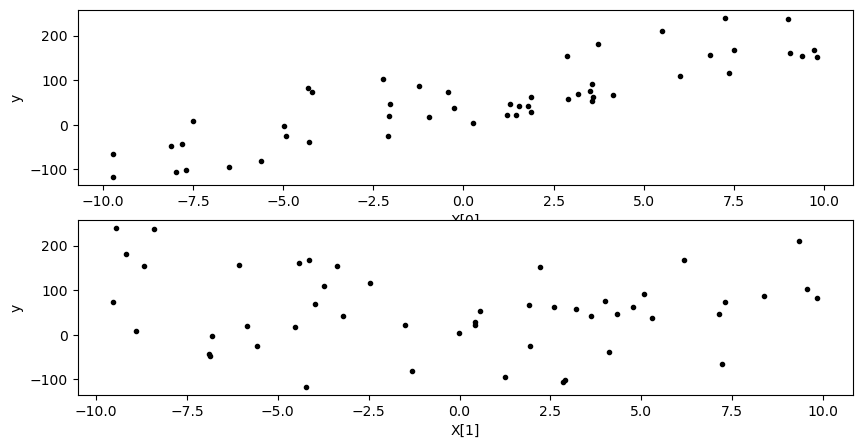

In [16]:
n_dim = X_array.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,5))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X_array[i], y_array, 'k.',)
    curr_ax.set_xlabel("X[%i]"%(i))
    curr_ax.set_ylabel("y")
plt.show()

In [17]:
# ------ Vectors ------
# Stack of all input variables
X = torch.tensor(X_array).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(y_array).to(DEVICE)

# ------ Constants ------
const1 = torch.tensor(np.array(1.)).to(DEVICE)
m = torch.tensor(np.array(m)).to(DEVICE)
g = torch.tensor(np.array(g)).to(DEVICE)

## Run config

### Library config

In [18]:
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "exp", "log", "sin", "cos"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"z" : 0         , "v_z" : 1         , },
                "input_var_units"      : {"z" : [1, 0, 0] , "v_z" : [1, -1, 0], },
                "input_var_complexity" : {"z" : 1.        , "v_z" : 1.        , },
                # constants
                "constants"            : {"1" : const1    , "m" : m         , "g" : g          },
                "constants_units"      : {"1" : [0, 0, 0] , "m" : [0, 0, 1] , "g" : [1, -2, 0] },
                "constants_complexity" : {"1" : 1.        , "m" : 1.        , "g" : 1.         },
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                  "superparent_units" : [2, -2, 1],
                  "superparent_name"  : "E",
                }

### Free constant optimizer config

In [19]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 30,
                        'tol'     : 1e-6,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }

### Learning config

In [20]:
MAX_TRIAL_EXPRESSIONS = 2*1e6
BATCH_SIZE = int(1e3)
MAX_LENGTH = 35
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),                
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [21]:
reward_config = {
                 "reward_function"     : Reward.SquashedNRMSE,
                 "zero_out_unphysical" : True,
                }

In [22]:
learning_config = {
    # Batch related
    'batch_size'       : BATCH_SIZE,
    'max_time_step'    : MAX_LENGTH,
    'n_epochs'         : int(1e9), #int(MAX_TRIAL_EXPRESSIONS/BATCH_SIZE),
    # Loss related
    'gamma_decay'      : 0.7,
    'entropy_weight'   : 0.005,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : Reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'    : GET_OPTIMIZER,
}

### Priors config

In [23]:
priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 4, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 6, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                #("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
                #("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
                ("NestedTrigonometryPrior", {"max_nesting" : 1}),              
                 ]

### Cell config

In [24]:
cell_config = {
    "hidden_size" : 128,
    "n_layers"    : 1,
}

### Logger

In [25]:
run_logger     = RunLogger()
save_path_training_curves = 'model11k-MechanicalEnergy-run.png'
run_visualiser = RunVisualiser(epoch_refresh_rate = 10,
                               save_path = save_path_training_curves,
                               do_show   = True,
                               do_save   = True, )

### Run config

In [26]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

## Dummy epoch for prior tuning

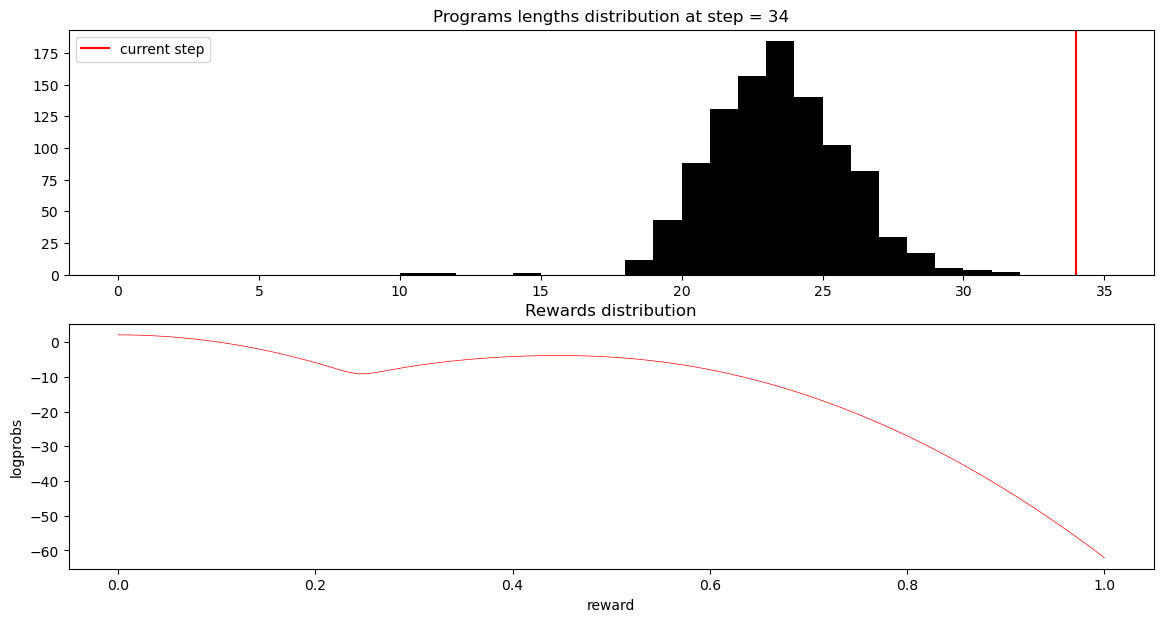

In [27]:
dummy_epoch(run_config)

## Sanity checks

Data


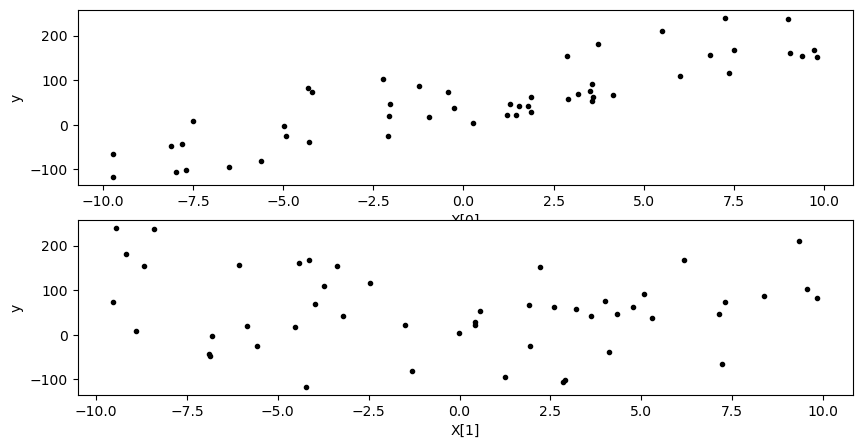

{'mul': 0, 'add': 1, 'sub': 2, 'div': 3, 'inv': 4, 'n2': 5, 'sqrt': 6, 'exp': 7, 'log': 8, 'sin': 9, 'cos': 10, '1': 11, 'm': 12, 'g': 13, 'z': 14, 'v_z': 15}
-------------------------- Library -------------------------
[mul add sub div inv n2 sqrt exp log sin cos 1 m g z v_z E dummy -]
--------------------------- Prior --------------------------
PriorCollection:
- HardLengthPrior (min_length = 4, max_length = 35)
- SoftLengthPrior (length_loc = 6, scale = 5)
- NoUselessInversePrior (['inv', 'log', 'exp', 'n2', 'sqrt'] can not be child of ['inv', 'exp', 'log', 'sqrt', 'n2'])
- PhysicalUnitsPrior
- NestedTrigonometryPrior (tokens = ['sin' 'cos'], nesting forbidden)
-------------------------- Dataset -------------------------
X        : torch.Size([2, 50]) 
y_target : torch.Size([50])
-------------------------- Programs ------------------------
[['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']
 ...
 ['dummy' '-' '-' ... '-' '-' '-']


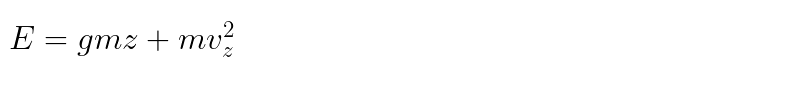

Simplified expression:


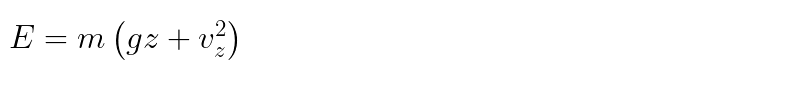

Ideal reward : 1.0


In [28]:
target_program = sanity_check(X, y, run_config, target_program_str=target_program_str)

## Run

  -> epoch 00030



KeyboardInterrupt



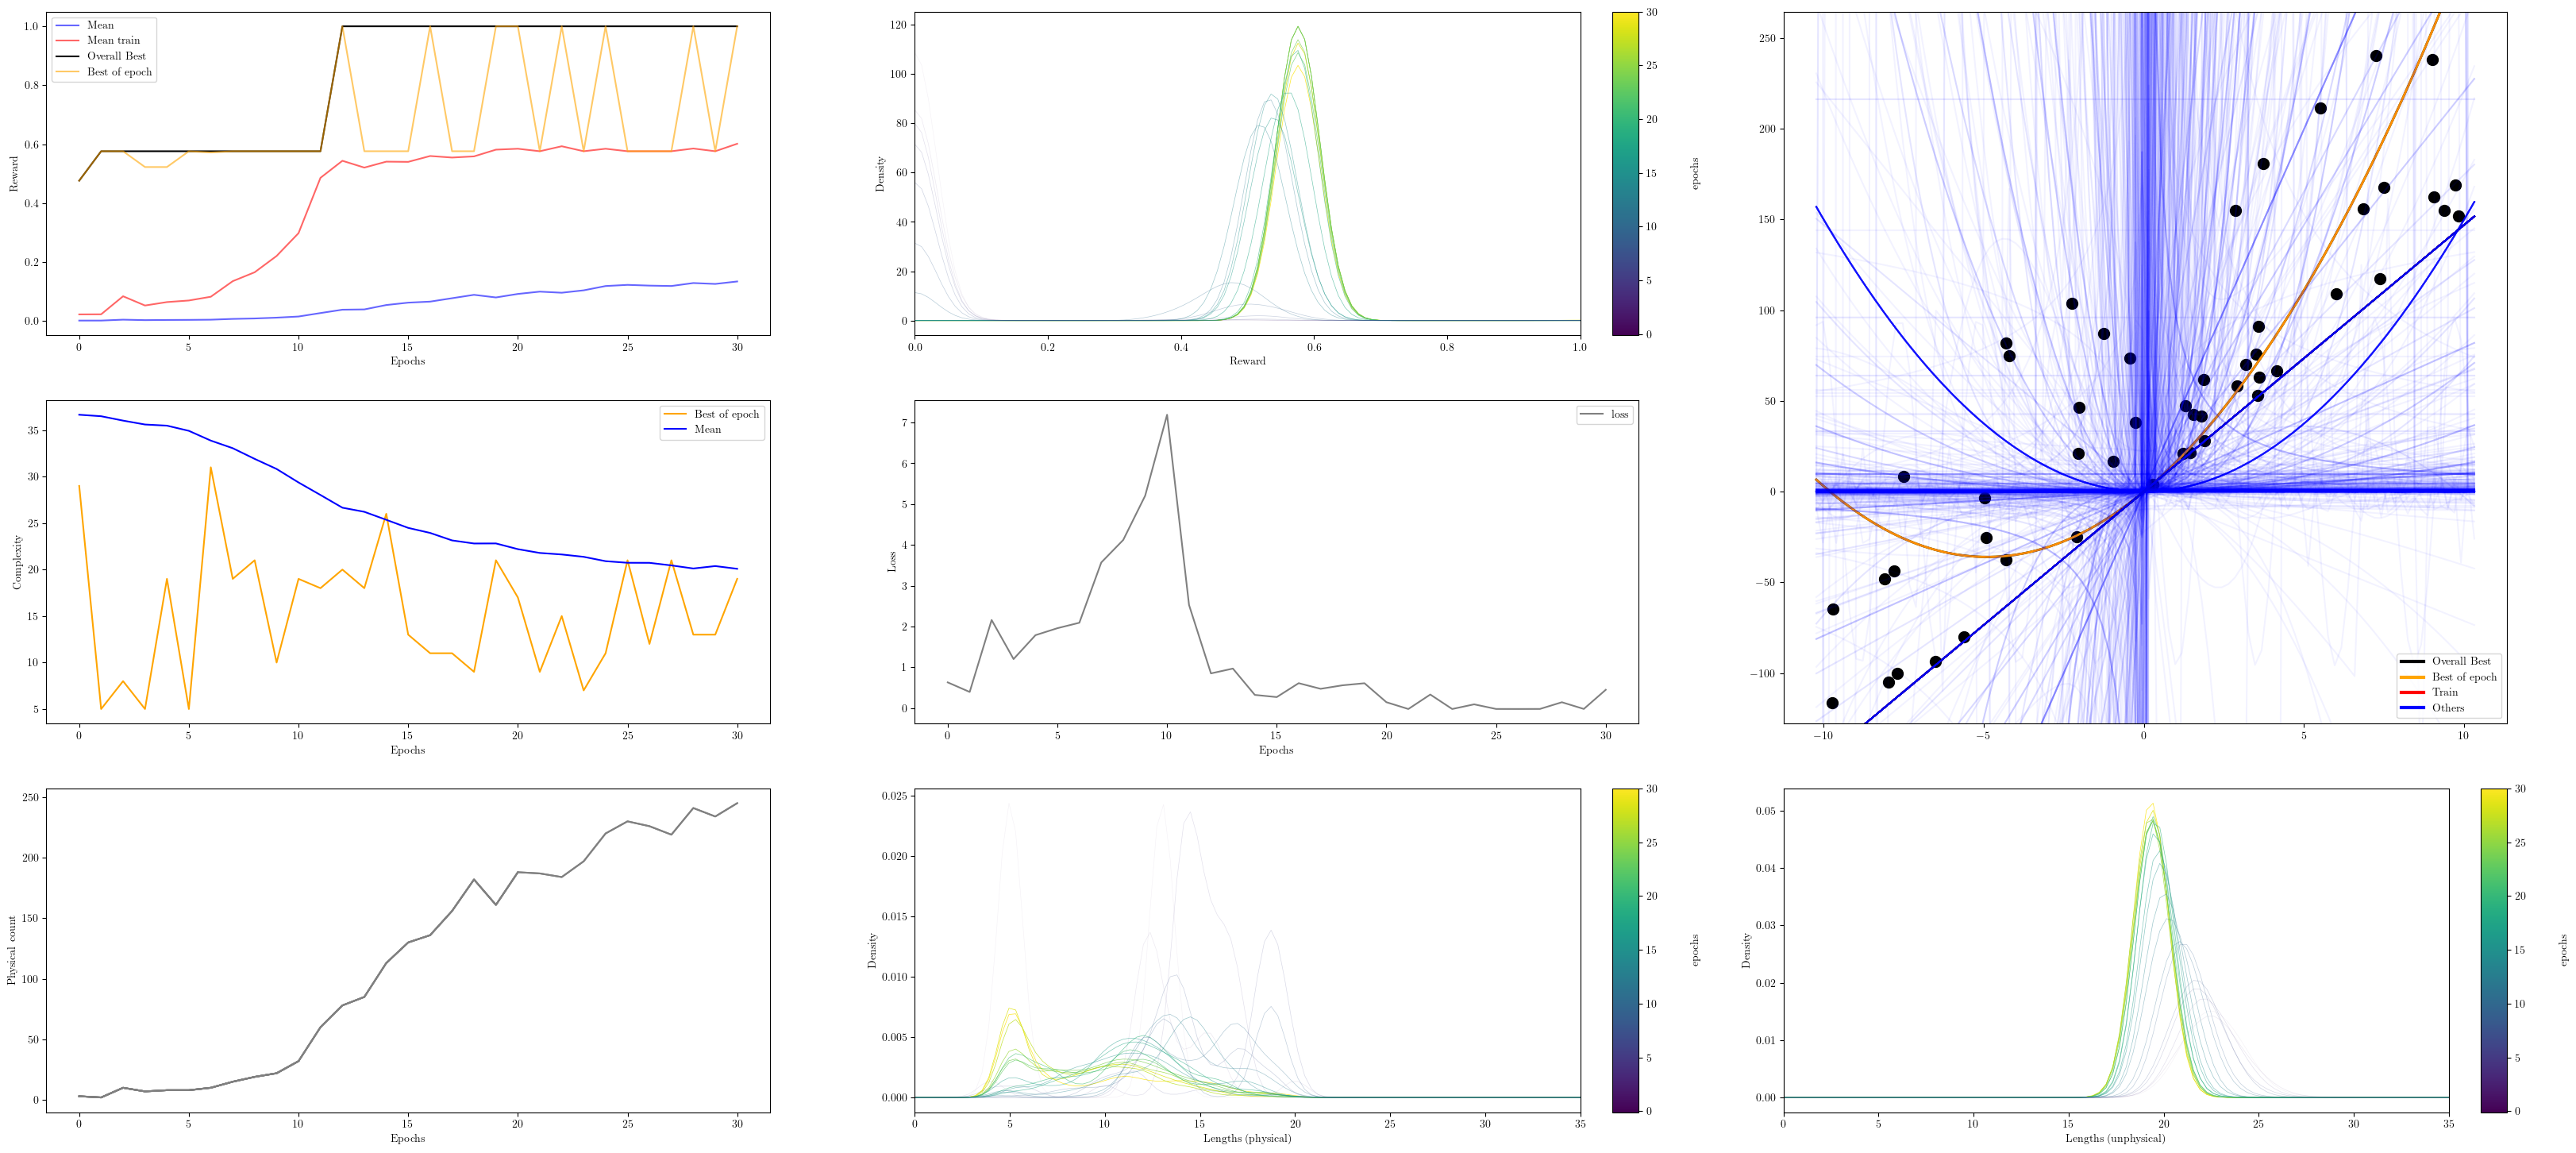

In [29]:
rewards, candidates = fit(X, y, run_config)

## Results

### Run plot

In [ ]:
run_visualiser.make_visualisation()

### Pareto Front

In [ ]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = np.log(pareto_front_rmse)
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("log(RMSE)")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)

In [ ]:
plot_pareto_front(run_logger)


In [ ]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()


In [ ]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)

### Symbolic equivalence

In [ ]:
best_prog_sympy   = candidates[-1] .get_infix_sympy(do_simplify=True)
target_prog_sympy = target_program .get_infix_sympy(do_simplify=True)

In [ ]:
target_prog_sympy

In [ ]:
best_prog_sympy

In [ ]:
target_prog_sympy == best_prog_sympy

In [ ]:
hall_of_fame = run_logger.hall_of_fame

In [ ]:
for i in range(len(hall_of_fame)):
    print(hall_of_fame[i].get_infix_sympy(do_simplify=False))

In [ ]:
eq = hall_of_fame[i].get_infix_sympy(do_simplify=True)

In [ ]:
eq.args

In [ ]:
import sympy

In [ ]:
sympy.parse_expr('((M*((c)**(2)))*((((((1-(((v)**(2))/((c)**(2)))))**(0.5)))**(-1))-cos(((1-(v/c))/pi))))')

In [ ]:
from sympy import symbols
x, y = symbols('x y')
expr = x + 2*y + x

In [ ]:
expr = sympy.simplify(expr)

In [ ]:
expr.args

In [ ]:
help(sympy.simplify)

In [ ]:
help(sympy.assumptions.refine)